<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/OB_vs_G_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [6]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Nauch/df_done_sub.csv') #выборка с уже объединеными подклассами звезд 
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,GALAXY,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,QSO,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,GALAXY,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,GALAXY,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,GALAXY,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757


In [8]:
df.shape

(4614588, 17)

In [9]:
df[df['objID'] == 1237648720142401611]

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
823072,1237648720142401611,146.71421,-1.041304,0.021222,0.000009,GALAXY,STARFORMING,19.08621,17.41779,16.59581,16.03497,15.68077,16.81934,15.38817,14.67877,14.25035,13.97063


In [ ]:
df = df.drop_duplicates('objID', keep = 'last')
df[df['objID'] == 1237648720142401611]

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
4162963,1237648720142401611,146.71421,-1.041304,0.021275,0.000009,GALAXY,NaN,19.08621,17.41779,16.59581,16.03497,15.68077,16.81934,15.38817,14.67877,14.25035,13.97063


In [10]:
df['ob'] = 1
df['ob'][df['subClass'] == 'OB'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
df1 = df.copy()

In [247]:
df = df[(df['class'] != 'STAR') | (df['ob'] == 0)] #оставляе в выборке только ОВ звезды, галактики и квазары
df.shape

(3667956, 18)

In [13]:
labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
df.replace({'class':labels}, inplace = True)
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,ob
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,2,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795,1
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,3,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354,1
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,2,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257,1
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,2,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923,1
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,2,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757,1


In [14]:
X =  df.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec', 'ob'], axis = 1).values
y = df['ob'].values
c = df['class'].values
c

array([2, 3, 2, ..., 3, 2, 2])

In [ ]:
df0 = pd.concat([df[df['ob']==0].sample(3000),  df[df['class']==2].sample(3000)])#, df[df['class']==3].sample(1000), df[df['ob']==1][df[df['ob']==1]['class']==1].sample(1000)])

In [ ]:
sns.pairplot(data = df0.drop(['class','subClass', 'objID', 'z', 'zErr', 'ra', 'dec'], axis = 1), palette = 'Dark2', hue = 'ob')

In [149]:
def data_preparation(X, y, c, test_size = 0.2): #бработка данных для классификаторов (бинарных и нет)
    count = np.min(((y==1).sum(), (y==0).sum()))
    print(count, (y==0).sum(), (y==1).sum())
    
    X0_train, X0_test, y0_train, y0_test = train_test_split(X[y==0], y[y==0], test_size=test_size, random_state = 43)
    #X1_train, X1_test, y1_train, y1_test = train_test_split(X[c==1][y[c==1]==1], y[c==1][y[c==1]==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[c==2], y[c==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[c==3], y[c==3], test_size=test_size, random_state = 43)
    
    count = X0_train.shape[0]
    count1 = X0_test.shape[0]
    #i1 = 5
    i2 = 4
    i3 = 2
    X_train, X_test = np.concatenate((X0_train[:count], X2_train[:count//i2], X3_train[:2*count//i3])), np.concatenate((X0_test, X2_test[:count1//2], X3_test[:count1//2]))
    y_train, y_test = np.concatenate((y0_train[:count], y2_train[:count//i2], y3_train[:2*count//i3])), np.concatenate((y0_test, y2_test[:count1//2], y3_test[:count1//2]))
    #X_train, X_test = np.concatenate((X0_train, X2_train, X3_train)), np.concatenate((X0_test, X2_test[:count1//2], X3_test[:count1//2]))
    #y_train, y_test = np.concatenate((y0_train, y2_train, y3_train)), np.concatenate((y0_test, y2_test[:count1//2], y3_test[:count1//2]))

    X_test_not_scaling = X_test.copy()
    X_train_not_scaling = X_train.copy()

    X0_train_not_scaling = X0_train.copy()
    X2_train_not_scaling = X2_train[:count//i2].copy()
    X3_train_not_scaling = X3_train[:2*count//i3].copy() 

    X0_test_not_scaling = X0_test.copy()
    X2_test_not_scaling = np.concatenate((X2_test, X2_train[count//i2:])).copy()
    X3_test_not_scaling = np.concatenate((X3_test, X3_train[count//i3:])).copy()

    robust = RobustScaler()

    X_train = robust.fit_transform(X_train)
    X0_test = robust.transform(X0_test)
    X0_train = robust.transform(X0_train)
    #X1_test = robust.transform(X1_test)
    #X1_train = robust.transform(X1_train)
    X2_test = robust.transform(np.concatenate((X2_test, X2_train[count//i2:])))
    y2_test = np.concatenate((y2_test, y2_train[count//i2:]))
    X2_train = robust.transform(X2_train[:count//i2])
    y2_train = y2_train[:count//i2]
    X3_test = robust.transform(np.concatenate((X3_test, X3_train[count//i3:])))
    y3_test = np.concatenate((y3_test, y3_train[count//i3:]))
    X3_train = robust.transform(X3_train[:count//i3])
    y3_train = y3_train[:count//i3]
    X_test = robust.transform(X_test)
    

    return X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test

In [150]:
X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_train_not_scaling, X2_train_not_scaling, X3_train_not_scaling, X0_test_not_scaling, X2_test_not_scaling, X3_test_not_scaling, X0_train, X0_test, y0_train, y0_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test = data_preparation(X, y, c)

13731 13731 3654225


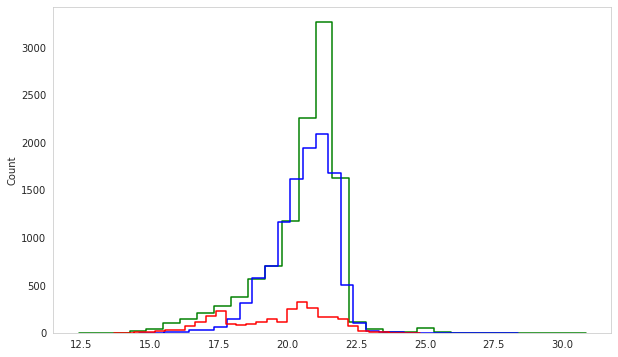

In [245]:
fig, ax1 = plt.subplots(ncols = 1, figsize = (10, 6))
sns.histplot(X0_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'g', element="step", fill=False)
sns.histplot(X3_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'b', element="step", fill=False)
sns.histplot(X2_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'r', element="step", fill=False)

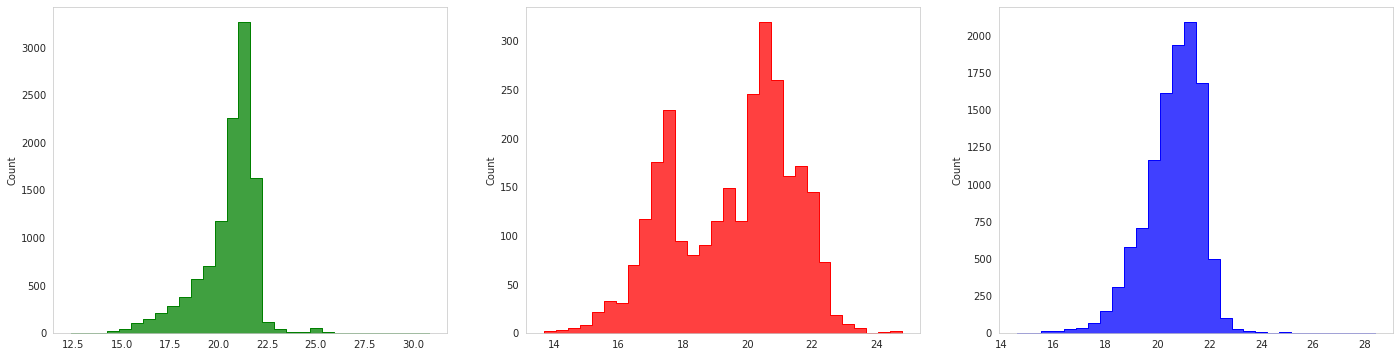

In [246]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(X0_train_not_scaling[:, 7], ax = ax1, bins = 30, color = 'g', element="step")
sns.histplot(X2_train_not_scaling[:, 7], ax = ax2, bins = 30, color = 'r', element="step")
sns.histplot(X3_train_not_scaling[:, 7], ax = ax3, bins = 30, color = 'b', element="step")

In [40]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25629, 10) (5493, 10) (25629,) (5493,)


In [ ]:
from sklearn.manifold import TSNE
idx = np.random.permutation(23653)
x_tmp = TSNE(2).fit_transform(X_train)
x_tmp = x_tmp[idx]
y_tmp = y_train[idx]

In [ ]:
import seaborn as sns

In [ ]:
aaa = (y_tmp != 1)
x_aaa = x_tmp[aaa]
y_aaa = y_tmp[aaa]
bbb = (y_tmp != 0)
x_bbb = x_tmp[bbb]
y_bbb = y_tmp[bbb]

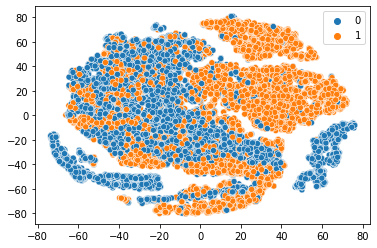

In [ ]:
sns.scatterplot(x=x_tmp[:, 0], y=x_tmp[:, 1], hue=y_tmp)

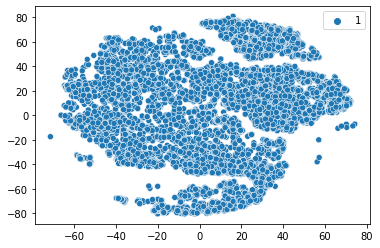

In [ ]:
sns.scatterplot(x=x_bbb[:, 0], y=x_bbb[:, 1], hue=y_bbb)

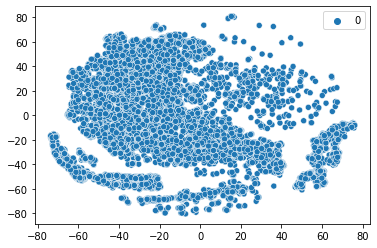

In [ ]:
sns.scatterplot(x=x_aaa[:, 0], y=x_aaa[:, 1], hue=y_aaa)

In [162]:
import time
t = time.time()
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train, y_train)
#rf = joblib.load('rf_new.pkl')
y_pred = rf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)
print(-t + time.time())

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2747
           1       0.88      0.91      0.89      2746

    accuracy                           0.89      5493
   macro avg       0.89      0.89      0.89      5493
weighted avg       0.89      0.89      0.89      5493

Confusion Matrix: 
 [[2390  357]
 [ 241 2505]]
Training Score:  1.0
Testing Score:  0.891134170762789
43.61212944984436


In [163]:
rf.feature_importances_

array([0.21802921, 0.14122197, 0.06721733, 0.05923266, 0.09607719,
       0.100812  , 0.08522348, 0.05596358, 0.07053367, 0.10568891])

In [160]:
from lightgbm import LGBMClassifier
#gb = joblib.load('gb.pkl')
gb = LGBMClassifier(n_estimators=950, num_leaves=60, learning_rate=0.01, max_depth=10)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb.score(X_train, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb.score(X_test, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2747
           1       0.88      0.91      0.89      2746

    accuracy                           0.89      5493
   macro avg       0.89      0.89      0.89      5493
weighted avg       0.89      0.89      0.89      5493

Confusion Matrix: 
 [[2401  346]
 [ 252 2494]]
Training Score:  0.8939872137250141
Testing Score:  0.891134170762789


In [161]:
joblib.dump(gb, 'gb.pkl')
gb.feature_importances_

array([9269, 6904, 5666, 4796, 5856, 5533, 4367, 4142, 4093, 5342])

In [ ]:
def print_plot2(ml, X_sub, y_sub, X_sub_test_not_scaling):
    
    X_test_not_scaling = X_sub_test_not_scaling[X_sub_test_not_scaling[:,7].argsort()]
    X_test = X_sub[X_sub_test_not_scaling[:,7].argsort()]
    y_test = y_sub[X_sub_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 10
    shift = len(y_test)//n
    precision = []
    recall = []
    f1 = []
    r_mean = []
    y_pred_all = ml.predict(X_test)

    for i in range(0, n):
            h = classification_report(y_test[i*shift : (i+1) * shift], y_pred_all[i*shift : (i+1) * shift], output_dict=True, zero_division=0)
            precision.append(h['0']['precision'])
            recall.append(h['0']['recall'])
            f1.append(h['0']['f1-score'])
            r_mean.append(X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean())
            
    plt.figure(figsize = (5,4))
    plt.title('Зависимость precision от признкака cModelMag_r:')
    plt.plot(r_mean, precision, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.figure(figsize = (5,4))
    plt.title('Зависимость recall от признкака cModelMag_r:')
    plt.plot(r_mean, recall, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.figure(figsize = (5,4))
    plt.title('Зависимость f1 от признкака cModelMag_r:')
    plt.plot(r_mean, f1, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)

In [ ]:
def roc(model, X_test, y_test, lab):
    from sklearn.metrics import roc_curve
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=lab)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show() 

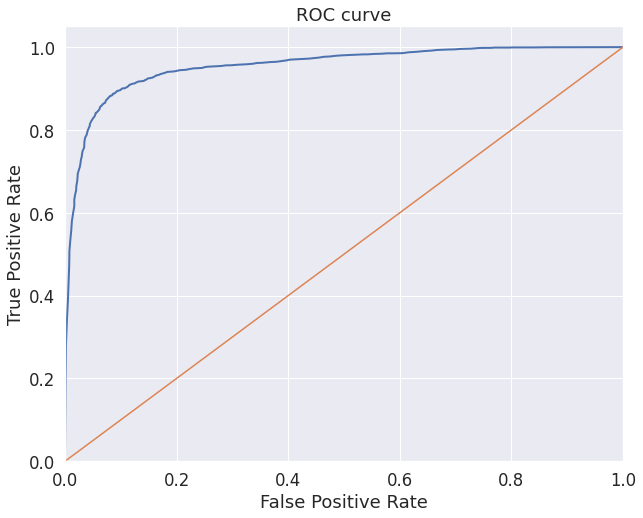

In [ ]:
roc(rf, X_test, y_test, 1)

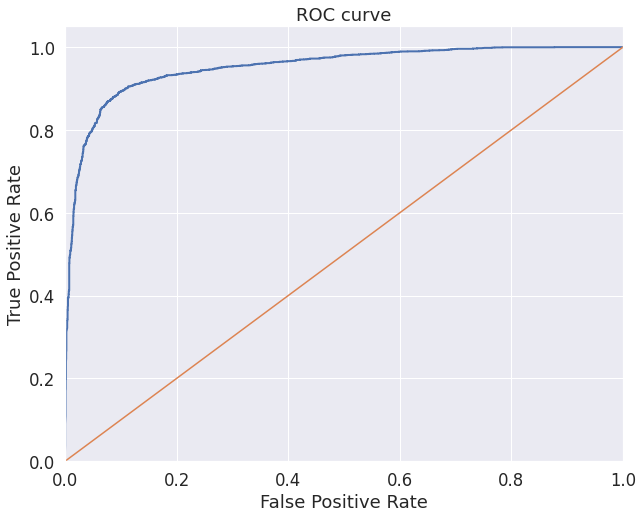

In [ ]:
roc(gb, X_test, y_test, 1)

In [239]:
def roc3D(ml, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling):
    from sklearn.metrics import roc_curve, auc
    
    X_test_not_scaling = X0_test_not_scaling[X0_test_not_scaling[:,7].argsort()]
    X_test = X0_test[X0_test_not_scaling[:,7].argsort()]
    y_test = y0_test[X0_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 15
    shift = len(y_test)//n
    fpr = []
    tpr = []
    r_mean = []
    AUC = []
    r = []
    #y_pred_all = ml.predict(X_test)
    y_pred_all_proba = ml.predict_proba(X_test)

    for i in range(0, n):
            r1 = X_test_not_scaling[i*shift][7]
            r2 = X_test_not_scaling[(i+1) * shift - 1][7]
            X = X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((X2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            y = y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((y2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            ind = np.random.choice(len(y), size=shift, replace=False)
            yt = np.concatenate((y_test[i*shift : (i+1) * shift], y[ind]))
            yp = np.concatenate((y_pred_all_proba[i*shift : (i+1) * shift], ml.predict_proba(X[ind])))
            f, t, thresholds = roc_curve(yt, yp[:,1], pos_label=1)
            fpr = np.concatenate((fpr, f))
            tpr = np.concatenate((tpr, t))
            r.append(X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean())
            AUC.append(auc(f, t))
            r_mean = np.concatenate((r_mean, [X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean()]*len(f)))
    return fpr, tpr, r_mean, AUC, r



1334 1334 1334


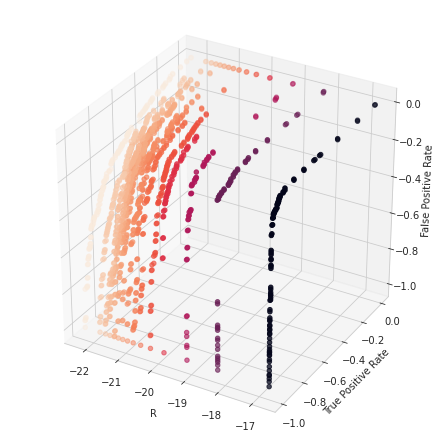

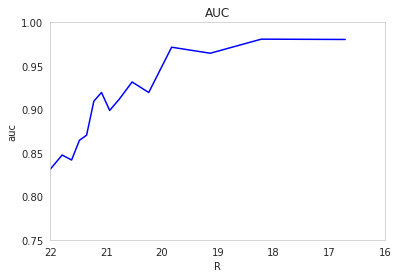

In [240]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) 
x, y, z, auc, r = roc3D(gb, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling)

print(len(x), len(y), len(z))
ax.scatter(-z, -y, -x, c=z, marker='o')
ax.set_xlabel('R')
ax.set_ylabel('True Positive Rate')
ax.set_zlabel('False Positive Rate')

plt.show()

plt.figure()
plt.title('AUC')
plt.plot(r, auc, 'b')
plt.plot([0,1],[0,1],'r--')
plt.ylim([0.75, 1])
plt.xlim([22,16])
plt.ylabel('auc')
plt.xlabel('R')
plt.show()

In [250]:
def prec_rec(ml, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    X_test_not_scaling = X0_test_not_scaling[X0_test_not_scaling[:,7].argsort()]
    X_test = X0_test[X0_test_not_scaling[:,7].argsort()]
    y_test = y0_test[X0_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 14
    shift = len(y_test)//n

    plt.figure(figsize=(10, 10))
    lines = []
    labels = []
    AP = []
    r = []
    clr = ['mediumorchid', 'blueviolet', 'royalblue', 'navy', 'darkslategrey', 'limegreen', 'lightgreen', 'greenyellow', 'yellow', 'orange', 'coral', 'r', 'magenta', 'black']
    #y_pred_all = ml.predict(X_test)
    y_pred_all_proba = ml.predict_proba(X_test)
    j = 0

    for i in range(0, n):
            r1 = X_test_not_scaling[i*shift][7]
            r2 = X_test_not_scaling[(i+1) * shift - 1][7]
            X = X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((X2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            y = y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((y2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            ind = np.random.choice(len(y), size=shift, replace=False)
            yt = np.concatenate((y_test[i*shift : (i+1) * shift], y[ind]))
            yp = np.concatenate((y_pred_all_proba[i*shift : (i+1) * shift], ml.predict_proba(X[ind])))

            f, t, thresholds = precision_recall_curve(yt, yp[:,1], pos_label=1)
            l, = plt.plot(t, f, color=clr[j], lw=2)
            j+=1
            lines.append(l)
            r1 = X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean()
            labels.append('r = ' + str(r1))
            r.append(r1)
            AP.append(average_precision_score(yt, yp[:,1]))
            
    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    #plt.xlim([15, 23])
    #plt.ylim([0.4, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Recall curve to multi-class')
    plt.legend(lines, labels, loc=(0, -0.7), prop=dict(size=14))
    plt.show()

    plt.figure()
    plt.title('AP')
    plt.plot(r, AP, 'b')
    plt.plot([0,1],[0,1],'r--')
    plt.ylim([0.75, 1])
    plt.xlim([22,16])
    plt.ylabel('AP')
    plt.xlabel('R')
    plt.show()

   # return fpr, tpr, r_mean, AUC, r

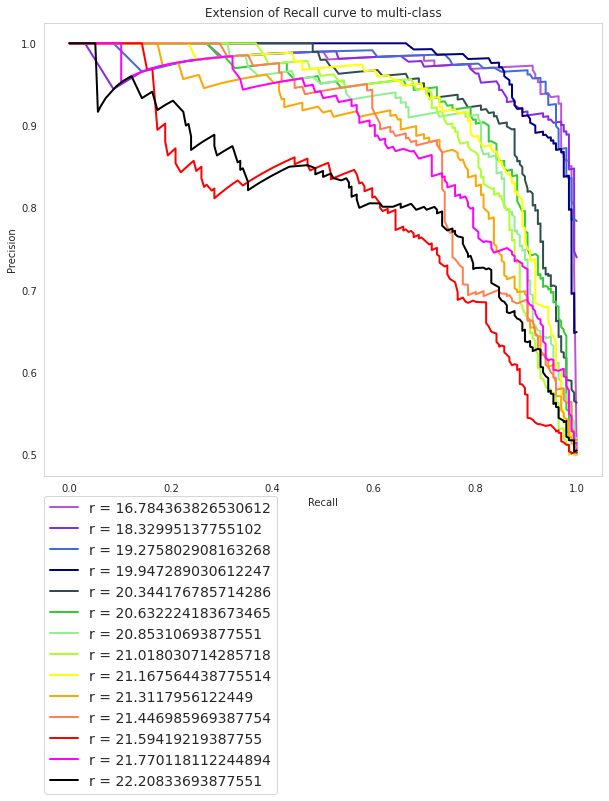

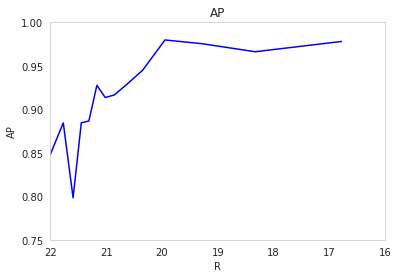

In [251]:
prec_rec(rf, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})


plt.figure(figsize=(10, 10))

lines = []
labels = [] 
x, y, z, auc, r = roc3D(gb, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling)

for i in len()
    l, = plt.plot(x, y, color=color, lw=2)
    lines.append(l)
    labels.append(

#print(len(x), len(y), len(z))
ax.scatter(-z, -y, -x, c=z, marker='o')
ax.set_xlabel('R')
ax.set_ylabel('True Positive Rate')
ax.set_zlabel('False Positive Rate')

plt.show()

plt.figure()
plt.title('AUC')
plt.plot(r, auc, 'b')
plt.plot([0,1],[0,1],'r--')
plt.ylim([0.75, 1])
plt.xlim([22,16])
plt.ylabel('auc')
plt.xlabel('R')
plt.show()

In [ ]:
def prec_rec3D(ml, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    X_test_not_scaling = X0_test_not_scaling[X0_test_not_scaling[:,7].argsort()]
    X_test = X0_test[X0_test_not_scaling[:,7].argsort()]
    y_test = y0_test[X0_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 15
    shift = len(y_test)//n
    Precision = []
    Recall = []
    r_mean = []
    AP = []
    r = []
    #y_pred_all = ml.predict(X_test)
    y_pred_all_proba = ml.predict_proba(X_test)

    for i in range(0, n):
            r1 = X_test_not_scaling[i*shift][7]
            r2 = X_test_not_scaling[(i+1) * shift - 1][7]
            X = X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((X2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            y = y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]#np.concatenate((y2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            ind = np.random.choice(len(y), size=shift, replace=False)
            yt = np.concatenate((y_test[i*shift : (i+1) * shift], y[ind]))
            yp = np.concatenate((y_pred_all_proba[i*shift : (i+1) * shift], ml.predict_proba(X[ind])))
            f, t, thresholds = precision_recall_curve(yt, yp[:,1], pos_label=1)
            Precision = np.concatenate((Precision, f))
            Recall = np.concatenate((Recall, t))
            AP.append(average_precision_score(yt, yp[:,1]))
            r.append(X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean())
            
            r_mean = np.concatenate((r_mean, [X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean()]*len(f)))
    return Precision, Recall, r_mean,  AP, r

2014 2014 2014


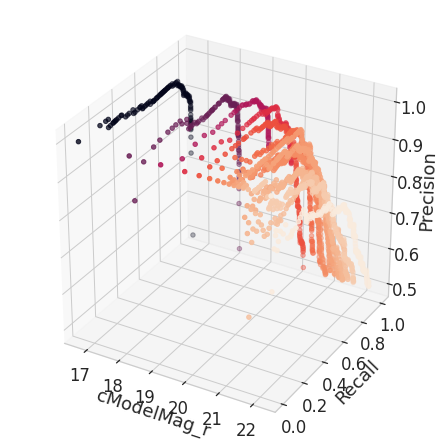

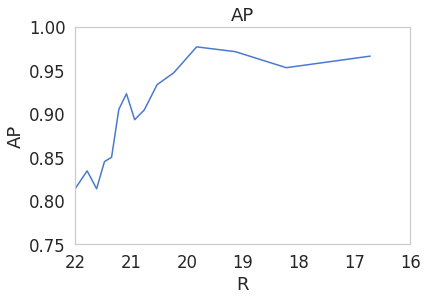

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) 
x, y, z, AP, r = prec_rec(gb, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling)

print(len(x), len(y), len(z))
ax.scatter(z, y, x, c=z, marker='o')
ax.set_xlabel('cModelMag_r')
ax.set_ylabel('Recall')
ax.set_zlabel('Precision')

plt.show()


In [ ]:
print_plot2(rf, X_test, y_test, X_test_not_scaling)

In [ ]:
print_plot2(rf, X_test, y_test, X_test_not_scaling)

In [ ]:
print_plot2(gb, X_test, y_test, X_test_not_scaling)

#Функции проверки полноты при фиксированной точности 

In [276]:
def THRESHOLD (yt, sp, p):
    t = 0
    maxt = np.zeros(2) #maxt[0] = pr max, maxt[1] = THRESHOLD max
    for THRESHOLD in np.arange(0.3, 1.01, 0.01).astype('float32'):
        #print(yt.shape)
        pred = (sp[:, 1] > (1 - THRESHOLD))*1
        #print(len(pred))
        TP = (pred == yt)[sp[:, 0] >= THRESHOLD].sum()
        FN = (pred != yt)[sp[:, 0] >= THRESHOLD].sum()
        FP = (pred != yt)[sp[:, 1] >= THRESHOLD].sum()
        TN = (pred == yt)[sp[:, 1] >= THRESHOLD].sum()
        pr = TP/(TP+FP)
        #print(THRESHOLD, pr)
        if pr >= p and pr!=1.0:
            t = THRESHOLD
            break
        #if pr > maxt[0] and pr!=1.0:
        #    maxt[0] = pr
        #    maxt[1] = THRESHOLD
    return t

In [270]:
def precis(yt, sp, THRESHOLD):
        pred = (sp[:, 1] > (1 - THRESHOLD))*1
        TP = (pred == yt)[sp[:, 0] >= THRESHOLD].sum()
        FN = (pred != yt)[sp[:, 0] >= THRESHOLD].sum()
        FP = (pred != yt)[sp[:, 1] >= THRESHOLD].sum()
        TN = (pred == yt)[sp[:, 1] >= THRESHOLD].sum()
        return TP/(TP+FP)
        

In [271]:
def recal(yt, sp, THRESHOLD):
        pred = (sp[:, 1] > (1 - THRESHOLD))*1
        TP = (pred == yt)[sp[:, 0] >= THRESHOLD].sum()
        FN = (pred != yt)[sp[:, 0] >= THRESHOLD].sum()
        FP = (pred != yt)[sp[:, 1] >= THRESHOLD].sum()
        TN = (pred == yt)[sp[:, 1] >= THRESHOLD].sum()
        return TP/(TP+FN)

In [277]:
def print_plot(ml, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling, name, prec=0.8):
    
    X_test_not_scaling = X0_test_not_scaling[X0_test_not_scaling[:,7].argsort()]
    X_test = X0_test[X0_test_not_scaling[:,7].argsort()]
    y_test = y0_test[X0_test_not_scaling[:,7].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 20
    shift = len(y_test)//n
    precision = []
    recall = []
    f1 = []
    r_mean = []
    threshold = []
    #y_pred_all = ml.predict(X_test)
    y_pred_all_proba = ml.predict_proba(X_test)

    for i in range(0, n):
            r1 = X_test_not_scaling[i*shift][7]
            r2 = X_test_not_scaling[(i+1) * shift - 1][7]
            X = np.concatenate((X2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], X3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            y = np.concatenate((y2_test[(X2_test_not_scaling[:, 7] >= r1) & (X2_test_not_scaling[:, 7] <= r2)], y3_test[(X3_test_not_scaling[:, 7] >= r1) & (X3_test_not_scaling[:, 7] <= r2)]))
            ind = np.random.choice(len(y), size=shift, replace=False)
            
            yt = np.concatenate((y_test[i*shift : (i+1) * shift], y[ind]))
            yp = np.concatenate((y_pred_all_proba[i*shift : (i+1) * shift], ml.predict_proba(X[ind])))
            p = THRESHOLD(yt, yp, prec)
            if p > 0:
                recall.append(recal(yt, yp, p))
                precision.append(precis(yt, yp, p))
                threshold.append(p)
                r_mean.append(X_test_not_scaling[i*shift : (i+1) * shift][:,7].mean())
            
    #plt.title('Зависимость recall от признкака cModelMag_r:'+name)
    #plt.plot(r_mean, recall, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    #plt.figure(figsize = (5,4))
    
    return precision, recall, threshold, r_mean

In [ ]:
test_precision = []
test_threshold = []
test_recall = []

for i in range(50):
    precision, recall, threshold, r_mean = print_plot(rf, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling, 'OB', 0.95)
    test_precision.append(precision)
    test_recall.append(recall)
    test_threshold.append(threshold)


<Figure size 360x288 with 0 Axes>

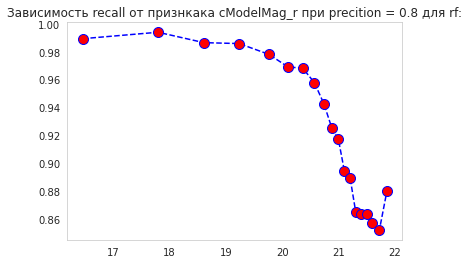

<Figure size 360x288 with 0 Axes>

In [260]:
plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.8 для rf:')
plt.plot(r_mean, np.mean(test_recall, axis=0), color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.figure(figsize = (5,4))

<Figure size 360x288 with 0 Axes>

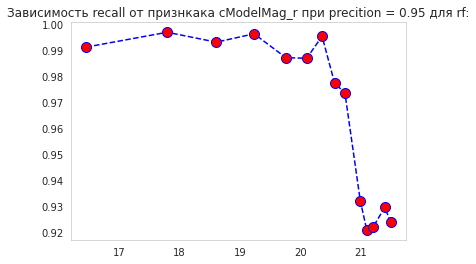

<Figure size 360x288 with 0 Axes>

In [262]:
plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.95 для rf:')
plt.plot(r_mean, np.mean(test_recall, axis=0), color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.figure(figsize = (5,4))

In [278]:
test_precision = []
test_threshold = []
test_recall = []

for i in range(50):
    precision, recall, threshold, r_mean = print_plot(gb, X0_test, y0_test, X0_test_not_scaling, X2_test, y2_test, X2_test_not_scaling, X3_test, y3_test, X3_test_not_scaling, 'OB', 0.80)
    test_precision.append(precision)
    test_recall.append(recall)
    test_threshold.append(threshold)

<Figure size 360x288 with 0 Axes>

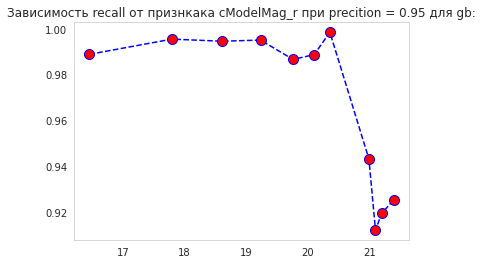

<Figure size 360x288 with 0 Axes>

In [264]:
plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.95 для gb:')
plt.plot(r_mean, np.mean(test_recall, axis=0), color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.figure(figsize = (5,4))

<Figure size 360x288 with 0 Axes>

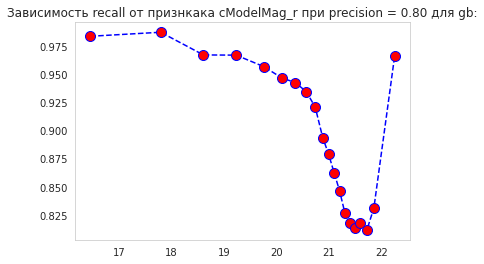

<Figure size 360x288 with 0 Axes>

In [279]:
plt.title('Зависимость recall от признкака cModelMag_r при precision = 0.80 для gb:')
plt.plot(r_mean, np.mean(test_recall, axis=0), color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.figure(figsize = (5,4))

In [ ]:
df_gaia = pd.read_csv('/content/drive/MyDrive/Nauch/gaia42.csv')
df_gaia.drop_duplicates(subset=['objid'])

,parallax,ra,dec,objid
0,8.704746,110.233809,24.574978,870120108853284224
1,3.217593,110.379225,25.246189,870179654279588608
2,3.982489,111.239082,24.767359,870182677936650112
3,2.864391,111.519944,25.383510,870243730895615488
4,6.940290,110.892950,25.380550,870266996734354688
...,...,...,...,...
12129649,1.757993,110.527600,23.916060,869847258170559872
12129650,5.664998,111.574508,24.312728,869921372126127232
12129651,3.257468,111.426799,24.407074,869970712710249472
12129652,3.241929,111.501912,24.506111,869972980452960896


In [ ]:
df_gaia.head()

,parallax,ra,dec,objid
0,8.704746,110.233809,24.574978,870120108853284224
1,3.217593,110.379225,25.246189,870179654279588608
2,3.982489,111.239082,24.767359,870182677936650112
3,2.864391,111.519944,25.383510,870243730895615488
4,6.940290,110.892950,25.380550,870266996734354688


In [ ]:
df4 = df1.copy()
df4 = df4.merge(df_gaia, left_on='objID', right_on='objid', how='inner')

In [ ]:
df4.shape

(0, 22)